# Introduction to the chemVAE
Matthew Roberts

This is an adapted work, originally created by https://github.com/aspuru-guzik-group/chemical_vae

## Load libraries

In [1]:
# tensorflow backend
from os import environ
environ['KERAS_BACKEND'] = 'tensorflow' #Sets backend of Keras to tensorflow - this can also be done manually
# vae stuff
from chemvae.vae_utils import VAEUtils
from chemvae import mol_utils as mu
# import scientific py
import numpy as np
import pandas as pd
# rdkit stuff
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import PandasTools
# plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import SVG, display
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Using TensorFlow backend.
D:\Anaconda\envs\chemvae\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda\envs\chemvae\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda\envs\chemvae\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda\envs\chemvae\lib\site-packages\tensorflow\python\framework\dtypes.py

# Load a model

Model files are developed by the VAE training, and the file path for the model that is desired to be used should be input below. Training a VAE is covered elsewhere.

In [2]:
vae = VAEUtils(directory='./models/USRCAT_250K')

From D:\Anaconda\envs\chemvae\lib\site-packages\keras\backend\tensorflow_backend.py:1210: calling reduce_prod (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
D:\Anaconda\envs\chemvae\lib\site-packages\keras\models.py:245: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
From D:\Anaconda\envs\chemvae\lib\site-packages\keras\backend\tensorflow_backend.py:1192: calling reduce_sum (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
From D:\Anaconda\envs\chemvae\lib\site-packages\keras\backend\tensorflow_backend.py:1156: calling reduce_max (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and 

Using standarized functions? True
Standarization: estimating mu and std values ...done!


# Using the VAE


## Decode/Encode 

Might not be perfect (it's probabilistic), try it several times.

smiles <i class="fa fa-arrow-right" aria-hidden="true"></i> x <i class="fa fa-arrow-right" aria-hidden="true"></i> z <i class="fa fa-arrow-right" aria-hidden="true"></i> x_r <i class="fa fa-arrow-right" aria-hidden="true"></i> smiles_r

The molecule input here will be used as the "seed" when searching for other molecules in the latent space.

In [78]:
input_smiles = str(input('SMILES: '))
smiles_1 = mu.canon_smiles(input_smiles)
#smiles_1 = mu.canon_smiles('CSCC(=O)NNC(=O)c1c(C)oc(C)c1C')

X_1 = vae.smiles_to_hot(smiles_1,canonize_smiles=True)
z_1 = vae.encode(X_1)
X_r= vae.decode(z_1)

print('{:20s} : {}'.format('Input',smiles_1))
print('{:20s} : {}'.format('Reconstruction',vae.hot_to_smiles(X_r,strip=True)[0]))

print('{:20s} : {} with norm {:.3f}'.format('Z representation',z_1.shape, np.linalg.norm(z_1)))

SMILES: C1C(=O)N(/C(=N/C(C)C)/NC2=CC=C(Cl)C(Cl)=C2)SC=1C
Input                : Cc1cc(=O)n(/C(=N/C(C)C)Nc2ccc(Cl)c(Cl)c2)s1
Reconstruction       : Cc1cc(=O)n(/C(=N/C(C)C)Nc2ccc(Cl)c(Cl)c2)s1
Z representation     : (1, 196) with norm 13.521


## Property Predictor

Predicts the properties of the inputted molecule (above).

In [79]:
print('Properties (qed,SAS,logP):')
y_1 = vae.predict_prop_Z(z_1)[0]
print(y_1)

Properties (qed,SAS,logP):
[0.71397316 2.5400763  3.8225527 ]


### Predicting properties of a dataset

In [ ]:
#Get DF of similarity data
simData = pd.read_csv("./Similarity of CDK2 Lit Mol and 250K Zinc with ChemBL Molecules/USRCAT_250K_With_ChemBL_Mols.csv")

x = 0
dataPred = np.array([])

for smi in simData.smiles:
    print ("Molecule No: {0} , Molecule Smiles: {1}".format(x, smi))
    dataX = vae.smiles_to_hot(smi,canonize_smiles=True)
    dataZ = vae.encode(dataX)
    dataY = vae.predict_prop_Z(dataZ)[0]
    dataPred = np.hstack((dataPred, dataY))
    print(dataPred)
    x += 1
    
#Save results
dataPredSim = np.hsplit(dataPred,253979) #May need to alter the number here depending on the length of the df
print(dataPredSim)
np.savetxt("Pred_Vals_Sort",dataPredSim)

## Generating Molecular Structures
VAE are probabilistic, therefore it may take several attempts to generate reasonable molecules.

You can change the decode_attempts to increase the number of times the code attempts to decode each vector. This may increase the number of molecules discovered, but also can result in less favourable structural generation (ie. structures generated may not fit with the expected structures.

You can also change the noise to increase the search radius within the latent space, however that may also effect structural generation. 

Searching molecules randomly sampled from 5.00 std (z-distance) from the point
Found 6 unique mols, out of 44
SMILES
 0    Cc1cc(=O)n(/C(=N/C(C)C)Nc2ccc(Cl)c(Cl)c2)s1
1    Cc1cc(=O)n(/C(=N\C(C)C)Nc2ccc(Cl)c(Cl)c2)s1
2    Cc1cc(=O)n(OC(=N\C(C)C)Nc2ccc(Cl)c(Cl)c2)s1
3    C1ccc(=O)n(/C(=N\C(C)C)Nc2ccc(Cl)c(Cl)c2)s1
4    C1ccc(=O)n(/C(=N/C(C)C)Nc2ccc(Cl)c(Cl)c2)s1
5    Cc1cc(=O)n(/C(=N\C(=C)C)c2ccc(Cl)c(Cl)c2)s1
Name: smiles, dtype: object


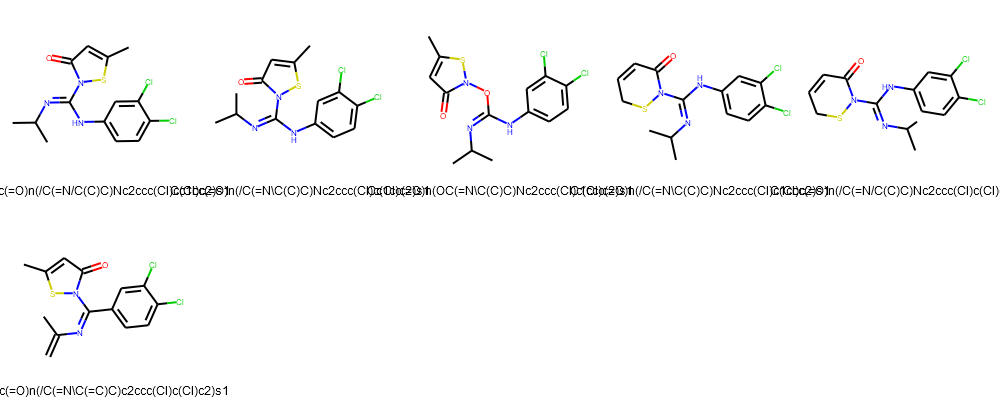

,smiles,distance,count,frequency,mol
0,Cc1cc(=O)n(/C(=N/C(C)C)Nc2ccc(Cl)c(Cl)c2)s1,0.000006,23,0.522727,"<img data-content=""rdkit/molecule"" src=""data:i..."
1,Cc1cc(=O)n(/C(=N\C(C)C)Nc2ccc(Cl)c(Cl)c2)s1,2.555480,15,0.340909,"<img data-content=""rdkit/molecule"" src=""data:i..."
2,Cc1cc(=O)n(OC(=N\C(C)C)Nc2ccc(Cl)c(Cl)c2)s1,9.291810,1,0.022727,"<img data-content=""rdkit/molecule"" src=""data:i..."
3,C1ccc(=O)n(/C(=N\C(C)C)Nc2ccc(Cl)c(Cl)c2)s1,19.213603,1,0.022727,"<img data-content=""rdkit/molecule"" src=""data:i..."
4,C1ccc(=O)n(/C(=N/C(C)C)Nc2ccc(Cl)c(Cl)c2)s1,19.357130,3,0.068182,"<img data-content=""rdkit/molecule"" src=""data:i..."


In [80]:
noise=5.0 #Can increase - original value was 5
print('Searching molecules randomly sampled from {:.2f} std (z-distance) from the point'.format(noise))
df = vae.z_to_smiles( z_1,decode_attempts=100,noise_norm=noise)
print('Found {:d} unique mols, out of {:d}'.format(len(set(df['smiles'])),sum(df['count'])))
print('SMILES\n',df.smiles)
display(PandasTools.FrameToGridImage(df,column='mol', legendsCol='smiles',molsPerRow=5))
df.head()

## PCA of latent space

A PCA of the latent space can be generated. This will help to outline the general shape and structure of the latent space with respect to a given molecular property that the code has been trained on.

Sample random points from the training set along with properties.

In [96]:
Z, data, smiles = vae.ls_sampler_w_prop(size=50000,return_smiles=True)
prop_opt = 'qed'
prop_df = pd.DataFrame(data).reset_index()
prop_df['smiles']=smiles
prop_df.head()

,index,logP,qed,SAS,smiles
0,165598,4.26752,0.503831,2.107885,Cc1ccc(NC(=O)CSc2nnc(-c3cc4ccccc4o3)n2C)cc1
1,136548,1.95732,0.855996,3.822449,Cc1cscc1C[NH2+][C@@H](C)C(=O)NC1CCCCC1
2,233491,1.52780,0.748026,3.149721,C[C@H]([NH3+])CCc1ccc(F)c(F)c1
3,143084,2.17300,0.877876,2.956832,COc1ccc([C@H](C)C(=O)NCC2(O)CCSCC2)cc1
4,109272,1.49580,0.910258,4.203915,C[C@@H](C(=O)N1c2ccccc2C[C@@H]1C)N1CC[NH+](C2C...


Perform a PCA projection and color the points based on a property

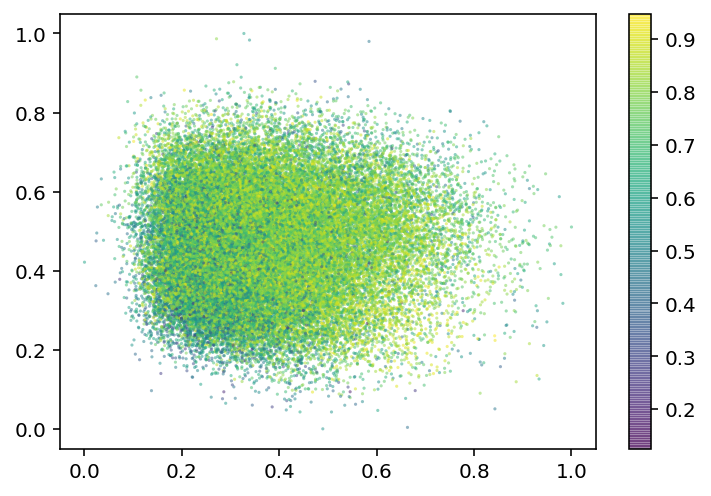

In [97]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# do pca and normalize
Z_pca = PCA(n_components=2).fit_transform(Z)
Z_pca = MinMaxScaler().fit_transform(Z_pca)

df = pd.DataFrame(np.transpose((Z_pca[:,0],Z_pca[:,1])))
df.columns = ['x','y']
df[prop_opt]=prop_df[prop_opt]

plt.scatter(x=df['x'], y=df['y'], c=df[prop_opt],
            cmap= 'viridis', marker='.',
            s=10,alpha=0.5, edgecolors='none')
plt.colorbar()
plt.show()

compare with t-SNE, will take some time

In [98]:
from sklearn.manifold import TSNE

Z_tsne = TSNE(n_components=2).fit_transform(Z)
Z_tsne = MinMaxScaler().fit_transform(Z_tsne)

f = pd.DataFrame(np.transpose((Z_tsne[:,0],Z_tsne[:,1])))
df.columns = ['x','y']
df[prop_opt]=prop_df[prop_opt]

plt.scatter(x=df['x'], y=df['y'], c=df[prop_opt],
            cmap= 'viridis', marker='.',
            s=10,alpha=0.5, edgecolors='none')
plt.show()

ValueError: Length mismatch: Expected axis has 3 elements, new values have 2 elements

## A Quick Analysis of Properties

In [ ]:
max_val = prop_df[prop_opt].max()
print('The max value for {:s} is {:f} in {:d} molecules randomly sampled from the data set.'.format(prop_opt,max_val,sample_size))

In [ ]:
max_mol = prop_df.groupby(prop_opt).max() #arranges dataframe of properties and SMILES to show min-to-max values
max_mol.iloc[[-1]].smiles #finds last in arranged dataframe (ie. largest value for prop_opt)
#max_mol